*First compiled: May 2, 2017. Updated Mar 28, 2018.*   
See the same notebook for Scanpy [0.4.4](https://github.com/theislab/scanpy_usage/blob/17c34b61f76de79bfdea7512f1782bf3f5ecb160/170502_paul15/paul15.ipynb).

# DPT for hematopoiesis in mouse [Paul *et al.*, Cell (2015)](http://doi.org/10.1016/j.cell.2015.11.013)

Hematopoiesis: trace myeloid and erythroid differentiation for data of [Paul *et al.*, Cell (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

**Note:** For a more recent and richer analysis of this dataset take a look at https://github.com/theislab/graph_abstraction/tree/master/paul15.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/paul15.h5ad'

scanpy==1.0 anndata==0.5.8 numpy==1.14.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


Perform a simple Diffusion Pseudotime analysis on raw data, as in [Haghverdi *et al.* (2016)](http://doi.org/10.1038/nmeth.3971). No preprocessing, only logarthmize the raw counts.

**Note**: The following function is also available as `sc.datasets.paul15()`.

In [2]:
import h5py
filename = 'data/paul15/paul15.h5'
backup_url = 'http://falexwolf.de/data/paul15.h5'
sc.utils.check_presence_download(filename, backup_url)
with h5py.File(filename, 'r') as f:
    X = f['data.debatched'][()]
    gene_names = f['data.debatched_rownames'][()].astype(str)
    cell_names = f['data.debatched_colnames'][()].astype(str)
    clusters = f['cluster.id'][()].flatten()
    infogenes_names = f['info.genes_strings'][()].astype(str)                                                                                                                                
# each row has to correspond to a sample, therefore transpose                                                                                                                    
adata = sc.AnnData(X.transpose())
adata.var_names = gene_names
adata.row_names = cell_names
# names reflecting the cell type identifications from the paper                                                                                                                                                                                                                                                    
cell_type = {7: 'MEP', 8: 'Mk', 9: 'GMP', 10: 'GMP', 11: 'DC',
             12: 'Baso', 13: 'Baso', 14: 'Mo', 15: 'Mo',
             16: 'Neu', 17: 'Neu', 18: 'Eos', 19: 'Lymph'}
cell_type.update({i: 'Ery' for i in range(1, 7)})
adata.obs['paul15_clusters'] = [
    str(i) + cell_type[i] for i in clusters.astype(int)]                                                                                                                   
# make string annotations categorical (optional)                                                                                                                           
sc.utils.sanitize_anndata(adata)                                                                                                                                                 
# just keep the first of the two equivalent names per gene                                                                                                                       
adata.var_names = [gn.split(';')[0] for gn in adata.var_names]                                                                                                       
# remove 10 corrupted gene names                                                                                                                                                 
infogenes_names = np.intersect1d(infogenes_names, adata.var_names)                                                                                                               
# restrict data array to the 3461 informative genes                                                                                                                              
adata = adata[:, infogenes_names]                                                                                                                                                
# usually we'd set the root cell to an arbitrary cell in the MEP cluster                                                                                                         
# adata.uns['iroot': np.flatnonzero(adata.obs['paul15_clusters']  == '7MEP')[0]                                                                                                
# here, set the root cell as in Haghverdi et al. (2016)                                                                                                                          
adata.uns['iroot'] = 840  # note that other than in Matlab/R, counting starts at 1

... storing 'paul15_clusters' as categorical


In [3]:
sc.pp.log1p(adata)  # logarithmize data

In [4]:
sc.pp.neighbors(adata, n_neighbors=20, use_rep='X', method='gauss')

computing neighbors
    finished (0:00:02.77) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [5]:
sc.tl.dpt(adata, n_branchings=1)

performing Diffusion Pseudotime analysis
    initialized `.distances` `.connectivities` 
    eigenvalues of transition matrix
    [1.         0.992215   0.966011   0.9404995  0.9273089  0.88551635
     0.8672743  0.84133327 0.82867014 0.80704373]
    finished (0:00:00.88) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


Diffusion Pseudotime (DPT) analysis detects the branch of granulocyte/macrophage progenitors (GMP), and the branch of megakaryocyte/erythrocyte progenitors (MEP). There are two small further subgroups (segments 0 and 2).

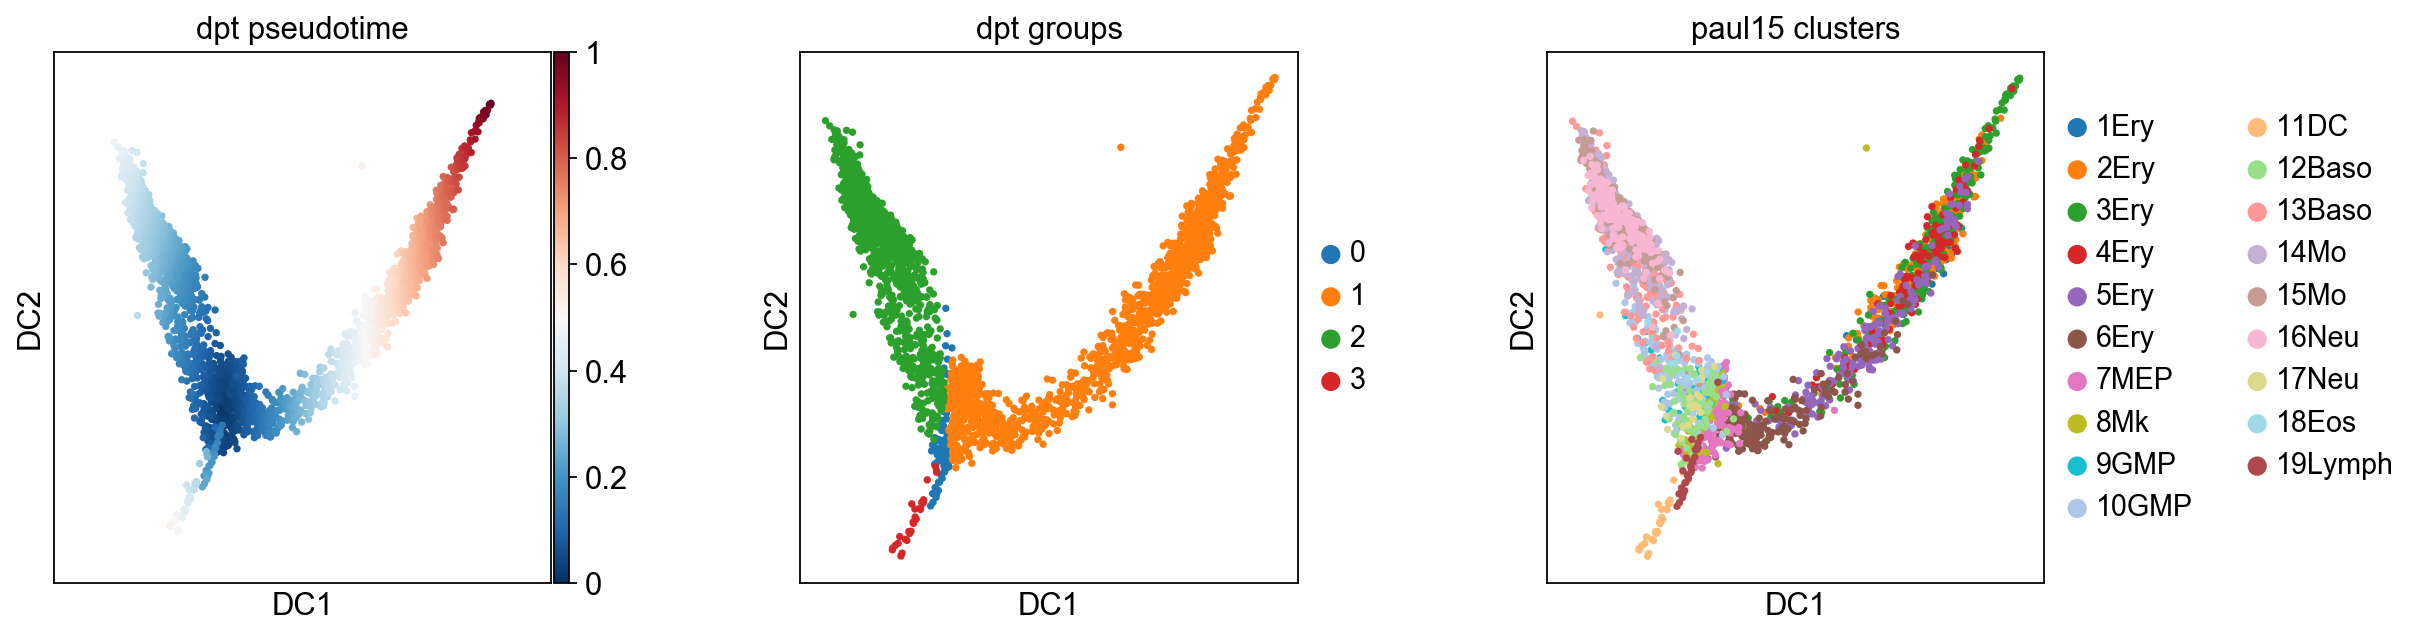

In [6]:
sc.pl.diffmap(adata, color=['dpt_pseudotime', 'dpt_groups', 'paul15_clusters'])

With this, we reproduced the analysis of [Haghverdi *et al.* (2016, Suppl. Note 4 and Suppl. Figure N4)](https://doi.org/10.1038/nmeth.3971).

In [7]:
adata.write(results_file)

Computing connectivities using UMAP gives us quantitiatively different results for the pseudotime.

In [8]:
sc.pp.neighbors(adata, n_neighbors=20, use_rep='X', method='umap')

computing neighbors
    initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
    finished (0:00:03.61) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [9]:
sc.tl.dpt(adata, n_branchings=1)

performing Diffusion Pseudotime analysis
    initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
    eigenvalues of transition matrix
    [1.         0.993715   0.9717146  0.95699656 0.94785434 0.91000646
     0.89768046 0.8868277  0.8667819  0.8511888 ]
    finished (0:00:00.85) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


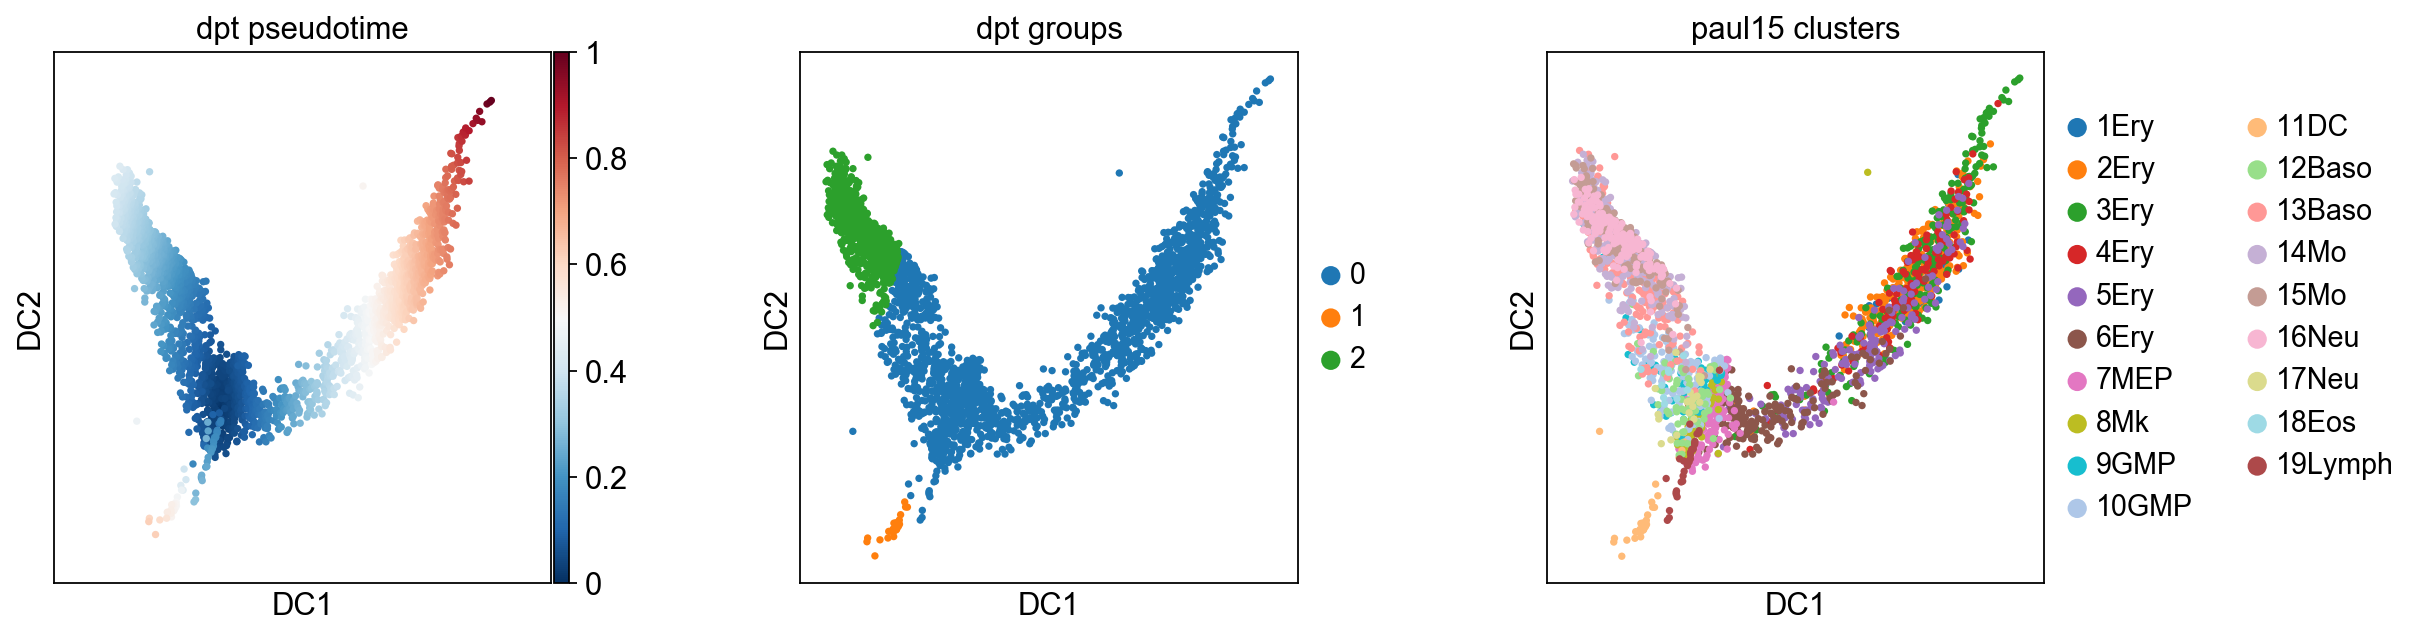

In [10]:
sc.pl.diffmap(adata, color=['dpt_pseudotime', 'dpt_groups', 'paul15_clusters'])